Training Adaptive λ LR: 1.00e-07: 100%|██████████| 20000/20000 [00:27<00:00, 731.81it/s, total_loss=1.291415e-01, pde_loss=1.282707e-03, bc_loss=1.022772e-05]           


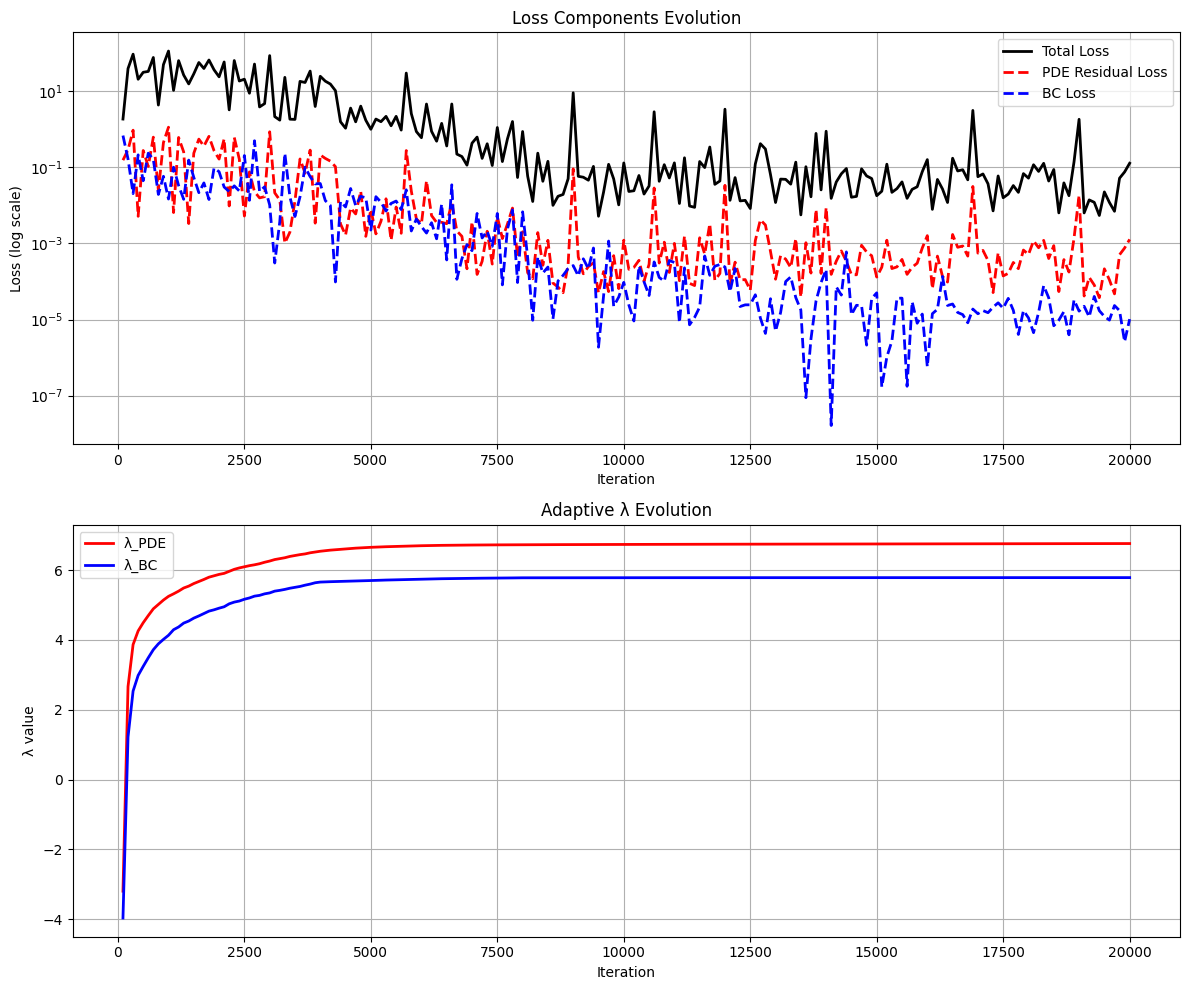

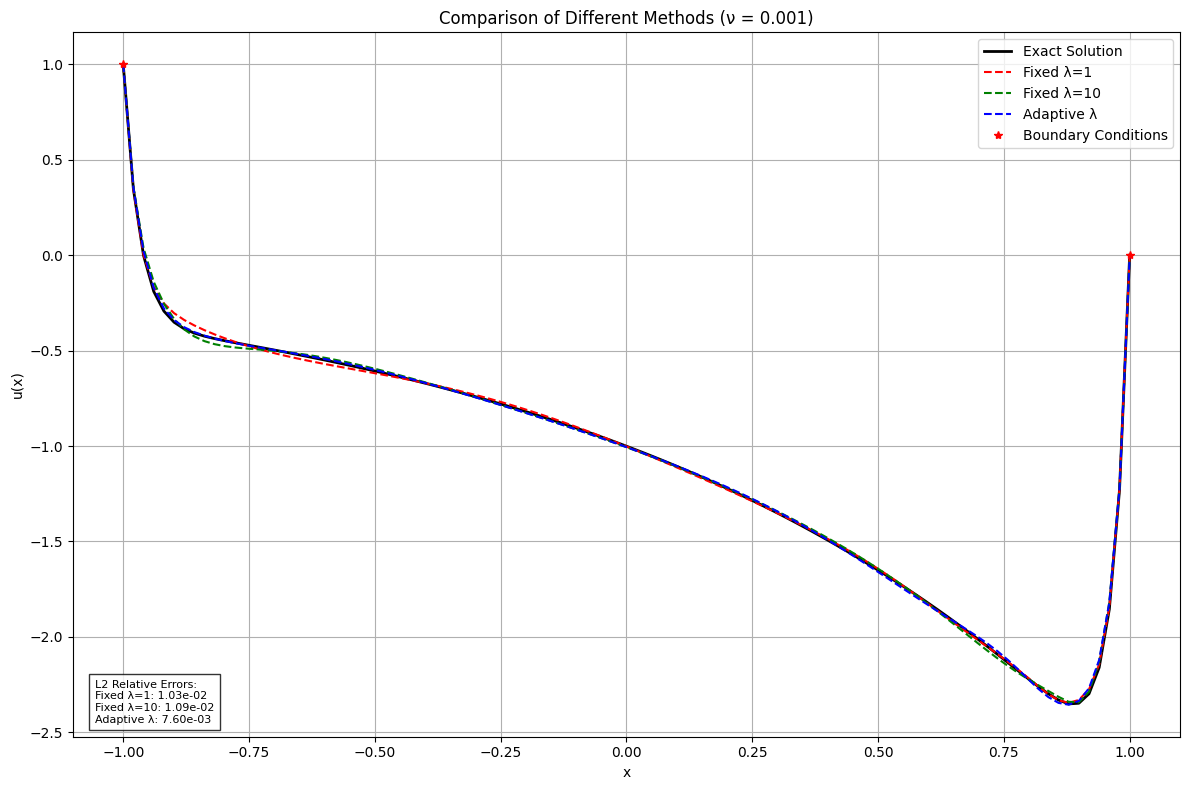

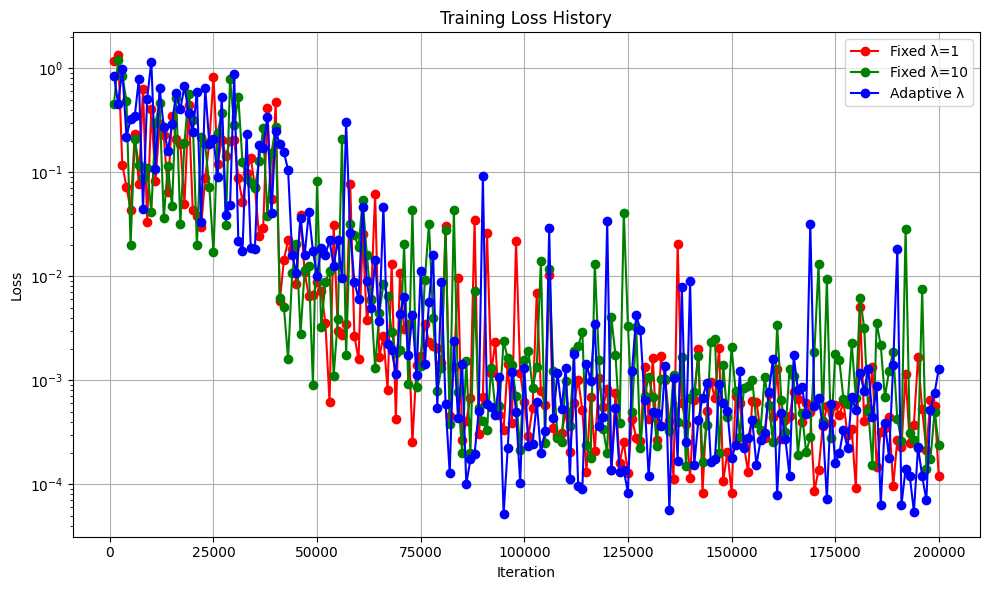


Final L2 relative errors:
Fixed λ=1: 1.033354e-02
Fixed λ=10: 1.087209e-02
Adaptive λ: 7.599156e-03


In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import List, Tuple, Dict
from tqdm import tqdm

@dataclass
class ModelConfig:
    """Configuration for the neural network model."""
    input_dim: int
    hidden_layers: List[int]
    output_dim: int
    activation: nn.Module = nn.Tanh()
    device: torch.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

@dataclass
class TrainingConfig:
    """Configuration for the training process."""
    epochs: int = 20000
    batch_size: int = 16
    initial_lr: float = 0.01
    lr_decay_factor: float = 0.1
    lr_decay_epochs: int = 4000
    lambda_pde_init: float = -4.6  # Initial lambda for PDE residual
    lambda_bc_init: float = -4.6   # Initial lambda for boundary conditions
    adaptive_lambda: bool = False
    adaptive_rate: float = 0.01

class PINN(nn.Module):
    """Physics-Informed Neural Network for solving differential equations."""
    
    def __init__(self, config: ModelConfig):
        super().__init__()
        self.layers = self._build_layers(config)
        self.activation = config.activation
        self.device = config.device
        
    def _build_layers(self, config: ModelConfig) -> nn.ModuleList:
        """Construct neural network layers with Xavier initialization."""
        layer_sizes = [config.input_dim] + config.hidden_layers + [config.output_dim]
        layers = nn.ModuleList()
        
        for i in range(len(layer_sizes) - 1):
            layer = nn.Linear(layer_sizes[i], layer_sizes[i + 1])
            nn.init.xavier_normal_(layer.weight)
            nn.init.zeros_(layer.bias)
            layers.append(layer)
            
        return layers
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass through the network."""
        for i, layer in enumerate(self.layers[:-1]):
            x = self.activation(layer(x))
        return self.layers[-1](x)
    
class DiffEqSolver:
    """Solver for differential equations using PINN."""
    
    def __init__(self, model_config: ModelConfig, training_config: TrainingConfig):
        self.model = PINN(model_config).to(model_config.device)
        self.config = training_config
        self.device = model_config.device
        self.nu = 0.001  # Diffusion coefficient
        
    def _adaptive_weight(self, lambda_val: float) -> float:
        """Calculate adaptive weight."""
        return 100 / (1 + np.exp(-lambda_val))
    
    def _compute_pde_residual(self, x: torch.Tensor, u: torch.Tensor) -> torch.Tensor:
        """Compute the PDE residual."""
        du = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), 
                               create_graph=True)[0]
        d2u = torch.autograd.grad(du, x, grad_outputs=torch.ones_like(du), 
                                create_graph=True)[0]
        return self.nu * d2u - u - torch.exp(x)
    
    def _compute_loss(self, x: torch.Tensor, lambda_pde: float, lambda_bc: float) -> Tuple[torch.Tensor, float, float]:
        """Compute total loss with separate weights for PDE and BC."""
        u = self.model(x)
        pde_residual = self._compute_pde_residual(x, u)
        pde_loss = torch.mean(pde_residual**2)
        
        left = torch.tensor([-1.]).reshape(1, 1).to(self.device)
        right = torch.tensor([1.]).reshape(1, 1).to(self.device)
        bc_loss = torch.mean((self.model(left) - 1)**2 + (self.model(right) - 0)**2)
        
        # Apply separate adaptive weights
        w_pde = self._adaptive_weight(lambda_pde)
        w_bc = self._adaptive_weight(lambda_bc)
        
        total_loss = w_pde * pde_loss + w_bc * bc_loss
        return total_loss, pde_loss.item(), bc_loss.item()
    
    def train(self, desc: str = "Training") -> Tuple[List[float], List[float], List[float], List[float], List[float]]:
        """Train the model and return loss history."""
        optimizer = optim.Adam(self.model.parameters(), lr=self.config.initial_lr)
        lambda_pde = self.config.lambda_pde_init
        lambda_bc = self.config.lambda_bc_init
        
        total_losses = []
        pde_losses = []
        bc_losses = []
        lambda_pde_values = []
        lambda_bc_values = []
        
        pbar = tqdm(range(1, self.config.epochs + 1), desc=desc)
        for epoch in pbar:
            x = (2 * torch.rand(self.config.batch_size, 1) - 1).to(self.device)
            x.requires_grad_(True)
            
            optimizer.zero_grad()
            loss, pde_loss, bc_loss = self._compute_loss(x, lambda_pde, lambda_bc)
            loss.backward()
            optimizer.step()
            
            if self.config.adaptive_lambda:
                # Update both lambda values based on their respective losses
                lambda_pde += (self.config.adaptive_rate * pde_loss * 100 * 
                             np.exp(-lambda_pde) / (1 + np.exp(-lambda_pde))**2)
                lambda_bc += (self.config.adaptive_rate * bc_loss * 100 * 
                            np.exp(-lambda_bc) / (1 + np.exp(-lambda_bc))**2)
                pbar.set_description(f'{desc} (λ_pde={lambda_pde:.2f}, λ_bc={lambda_bc:.2f})')
            
            if epoch % self.config.lr_decay_epochs == 0:
                for param_group in optimizer.param_groups:
                    param_group['lr'] *= self.config.lr_decay_factor
                pbar.set_description(f'{desc} LR: {param_group["lr"]:.2e}')
            
            if epoch % 100 == 0:
                total_losses.append(loss.item())
                pde_losses.append(pde_loss)
                bc_losses.append(bc_loss)
                lambda_pde_values.append(lambda_pde)
                lambda_bc_values.append(lambda_bc)
                pbar.set_postfix({
                    'total_loss': f'{loss.item():.6e}',
                    'pde_loss': f'{pde_loss:.6e}',
                    'bc_loss': f'{bc_loss:.6e}'
                })
        
        return total_losses, pde_losses, bc_losses, lambda_pde_values, lambda_bc_values


def plot_detailed_losses(losses: Tuple[List[float], List[float], List[float], List[float], List[float]]):
    """Plot detailed loss components and lambda evolution."""
    total_losses, pde_losses, bc_losses, lambda_pde_values, lambda_bc_values = losses
    epochs = range(100, len(total_losses) * 100 + 1, 100)
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Plot losses
    ax1.semilogy(epochs, total_losses, 'k-', label='Total Loss', linewidth=2)
    ax1.semilogy(epochs, pde_losses, 'r--', label='PDE Residual Loss', linewidth=2)
    ax1.semilogy(epochs, bc_losses, 'b--', label='BC Loss', linewidth=2)
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Loss (log scale)')
    ax1.set_title('Loss Components Evolution')
    ax1.grid(True)
    ax1.legend()
    
    # Plot lambda evolution
    ax2.plot(epochs, lambda_pde_values, 'r-', label='λ_PDE', linewidth=2)
    ax2.plot(epochs, lambda_bc_values, 'b-', label='λ_BC', linewidth=2)
    ax2.set_xlabel('Iteration')
    ax2.set_ylabel('λ value')
    ax2.set_title('Adaptive λ Evolution')
    ax2.grid(True)
    ax2.legend()
    
    plt.tight_layout()
    return fig


def exact_solution(x: np.ndarray) -> np.ndarray:
    """Compute the exact solution of the differential equation."""
    c1 = ((1 + 1000/np.exp(1)/999)*np.exp((-10*np.sqrt(10))) - 
          np.exp(10*np.sqrt(10))*1000*np.exp(1)/999) / (np.exp(-20*np.sqrt(10)) - 
          np.exp(20*np.sqrt(10)))
    c2 = (np.exp(-10*np.sqrt(10))*1000*np.exp(1)/999  - 
          np.exp(10*np.sqrt(10)) * (1+1000/np.exp(1)/999)) / (np.exp(-20*np.sqrt(10)) - 
          np.exp(20*np.sqrt(10)))
    return (c1*np.exp(10*np.sqrt(10)*x) + c2*np.exp(-10*np.sqrt(10)*x) - 
            (1000/999)*np.exp(x))

def plot_comparison(solvers: Dict[str, DiffEqSolver], x_plot: np.ndarray, 
                   y_exact: np.ndarray) -> Dict[str, float]:
    """Plot comparison of different methods and return their errors."""
    plt.figure(figsize=(12, 8))
    plt.plot(x_plot, y_exact, 'k-', label='Exact Solution', linewidth=2)
    
    colors = ['r--', 'g--', 'b--']
    errors = {}
    
    for (name, solver), color in zip(solvers.items(), colors):
        x_tensor = torch.tensor(x_plot.reshape(-1, 1), dtype=torch.float32).to(solver.device)
        with torch.no_grad():
            y_pred = solver.model(x_tensor).cpu().numpy()
        
        errors[name] = np.linalg.norm(y_exact - y_pred.flatten()) / np.linalg.norm(y_exact)
        plt.plot(x_plot, y_pred, color, label=name, linewidth=1.5)
    
    plt.plot([-1, 1], [1, 0], 'r*', label='Boundary Conditions')
    plt.xlabel('x')
    plt.ylabel('u(x)')
    plt.title('Comparison of Different Methods (ν = 0.001)')
    plt.grid(True)
    plt.legend()
    
    # Add error text box
    error_text = '\n'.join([f'{name}: {error:.2e}' for name, error in errors.items()])
    plt.text(0.02, 0.02, f'L2 Relative Errors:\n{error_text}',
             transform=plt.gca().transAxes, 
             bbox=dict(facecolor='white', alpha=0.8), 
             fontsize=8)
    
    plt.tight_layout()
    return errors

def plot_losses(all_losses: Dict[str, List[float]]):
    """Plot training loss history for all methods."""
    plt.figure(figsize=(10, 6))
    colors = ['r-o', 'g-o', 'b-o']
    
    for (name, losses), color in zip(all_losses.items(), colors):
        plt.semilogy(range(1000, len(losses) * 1000 + 1, 1000), 
                    losses, color, label=name)
    
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Training Loss History')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()

def main():
    # Set random seeds
    torch.manual_seed(42)
    np.random.seed(42)
    
    # Base configurations
    model_config = ModelConfig(
        input_dim=1,
        hidden_layers=[16, 16, 16],
        output_dim=1
    )
    
    # Create solvers with different lambda strategies
    solvers = {}
    training_configs = {
        'Fixed λ=1': TrainingConfig(lambda_pde_init=-4.6, lambda_bc_init=-4.6, adaptive_lambda=False),
        'Fixed λ=10': TrainingConfig(lambda_pde_init=-2.2, lambda_bc_init=-2.2, adaptive_lambda=False),
        'Adaptive λ': TrainingConfig(lambda_pde_init=-4.6, lambda_bc_init=-4.6, adaptive_lambda=True),
    }
    
    # Train all models
    all_losses = {}
    adaptive_losses = None
    for name, config in training_configs.items():
        solver = DiffEqSolver(model_config, config)
        losses, pde_losses, bc_losses, lambda_pde_values, lambda_bc_values = solver.train(desc=f'Training {name}')
        if name == 'Adaptive λ':
            adaptive_losses = (losses, pde_losses, bc_losses, lambda_pde_values, lambda_bc_values)
        solvers[name] = solver
        all_losses[name] = np.array(pde_losses) + np.array(bc_losses) #losses    

    # Plot detailed losses
    plot_detailed_losses(adaptive_losses)
    plt.show()

    # Generate comparison data
    x_plot = np.linspace(-1, 1, 100)
    y_exact = exact_solution(x_plot)
    
    # Plot comparisons
    errors = plot_comparison(solvers, x_plot, y_exact)
    plt.show()
    
    # Plot loss histories
    plot_losses(all_losses)
    plt.show()
    
    # Print final errors
    print('\nFinal L2 relative errors:')
    for name, error in errors.items():
        print(f'{name}: {error:.6e}')

if __name__ == "__main__":
    main()